# Dinâmica de canais iônicos individuais

$$\require{mhchem}$$       
A ideia desta atividade é simular o chaveamento (abertura / fechamento) de um canal iônico hipotético, cuja estrutura pode transicionar entre dois estados (conformações), "aberto" ou "fechado". Supomos também que as taxas de transição entre estes estados seja dependente do potencial de membrana − como é o caso para registros de Patch Clamp de canais individuais de Potássio:

<figure>
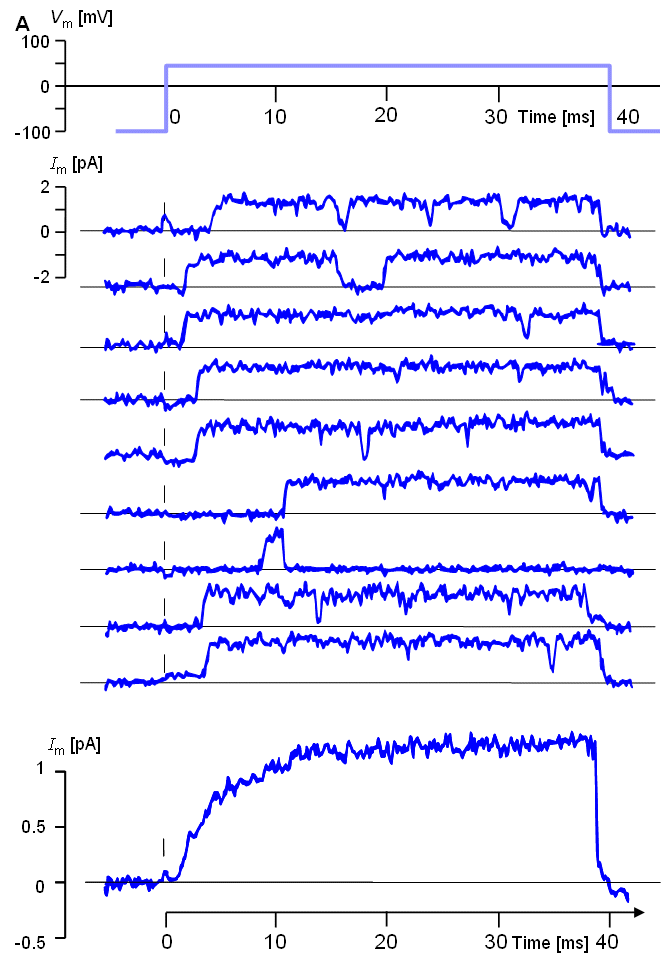
<center><figcaption align = "center"> Corrente em canais de Potássio (Voltage Clamp). Hille, 1992. </figcaption></center>
</figure>



Sejam $\alpha_n(V)$ e $\beta_n(V)$ as taxas de transição entre o estado aberto $A$ e o fechado $F$:

$$
\ce{F <=>[\alpha_n][\beta_n] A}
$$

Por conveniência, utilizaremos as mesmas formas para $\alpha_n(V)$ e $\beta_n(V)$ que as obtidas por Hodgkin e Huxley para o axônio gigante da lula:   

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def alpha_n(v):
    vv = -(v+40)
    return 0.1*vv/(np.exp(vv/10) - 1)

def beta_n(v):
    return 4*np.exp(-(v+65)/18)

No caso do axônio da lula, os registros envolviam médias sobre um número muito grande de canais no axônio − fazendo com que a dinâmica da variável de chaveamento $n$  ("ativação da condutância de Potássio) fosse bem descrita por uma relaxamento exponencial a um valor de equilíbrio controlado por $V$. Esse tipo de dinâmica é também conhecido como "carregamento de um capacitor" (elétrica) ou "cinética de primeira ordem" (química), correspondendo à equação:

$$
\frac{dn}{dt} = \frac{n_\infty - n}{\tau_n}
$$

sendo o valor estacionário $n_\infty$ e a constante temporal $\tau_n$ relacionadas com as taxas $\alpha_n, \beta_n$:

$$
\tau_n = \frac{1}{\alpha_n+\beta_n} \qquad n_\infty = \frac{\alpha_n}{\alpha_n+\beta_n}
$$

In [2]:
def tau_n(v):
    return 1/(alpha_n(v)+beta_n(v))

def n_inf(v):
    return alpha_n(v)*tau_n(v)

Para um potencial de membrana fixo, esta equação diferencial tem solução exata:
$$
n(t) = n_0 e^{-t/\tau_n} + n_\infty(1-e^{-t/\tau_n})
$$

In [3]:
def exata_n(t, v, n0):
    ninf = n_inf(v)
    tau = tau_n(v)
    relaxa = np.exp(-t/tau)
    return n0 * relaxa + ninf * (1 - relaxa)

Vamos estudar um protocolo que consiste em dois niveis de voltage clamp: manter o potencial em $-80\ \mathrm{mV}$ por $10\ \mathrm{ms}$, depois subir para $-20\ \mathrm{mV}$ por $10\ \mathrm{ms}$. 

Podemos usar a função `exata_n` definida na célula anterior para fazer um gráfico da solução do problema para um número grande de canais: 

<IPython.core.display.Javascript object>


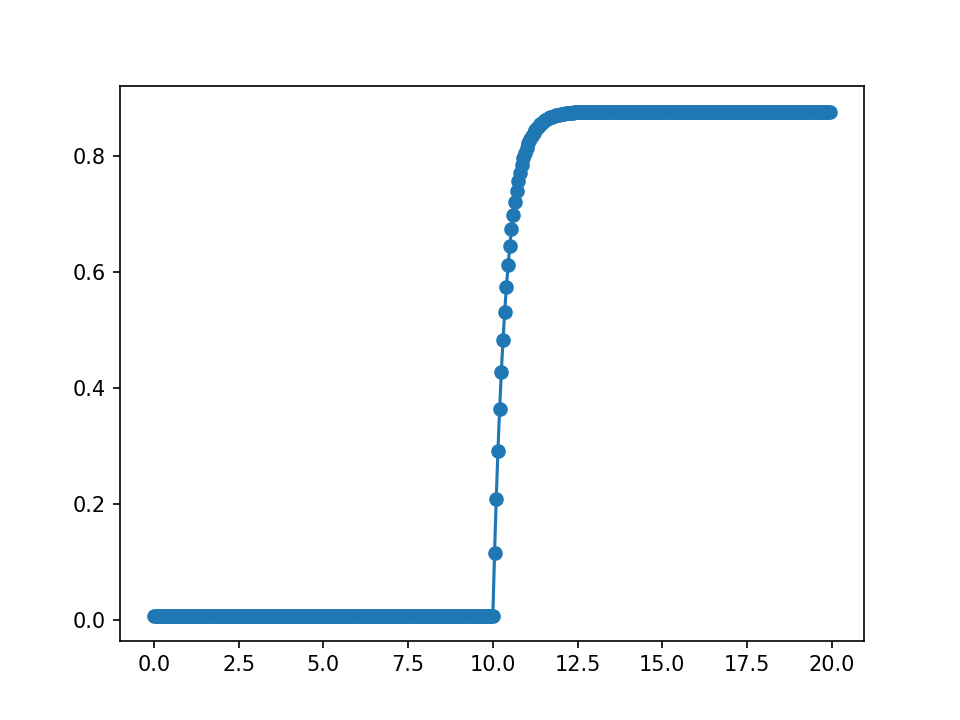

In [4]:
%matplotlib notebook

t0 = 0
tf = 20
passo = 0.05
tclamp = 10

t = np.arange(t0, tf, passo)  # simularemos 20 ms em passos de 0.05 ms
passos = len(t)
n = np.zeros(passos)  # espaço para guardar a solução exata n(t)

n[t < tclamp] = n_inf(-80) # até t = 10 ms, começamos e ficamos no valor 
                       # estacinário para V = -80 mV

# a partir de t = 10 ms, temos que calcular a solução para clamp de -20 mV
n[passos//2:] = exata_n((t[passos//2:]-10), -20, n_inf(-80))  
                                        
plt.plot(t, n, 'o-')
